# Lab 2: Working with Sentinel-2 COG data using `stackstac`

Extract Sentinel-2 COG data into xarray using [`stackstac`](https://github.com/gjoseph92/stackstac/tree/main) and visualize.

This code is based on [STAC + stackstac + xarray](https://hrodmn.dev/posts/stackstac/) content and is adapted for a SageMaker AI Studio notebook.

In [ ]:
%pip install --upgrade hvplot geoviews datashader pystac-client stackstac[viz] numpy panel

In [2]:
import numpy as np
import xarray as xr
import pystac_client
import panel as pn
import boto3
import sagemaker
import hvplot.xarray
import stackstac
import pyproj
from shapely.geometry import box
from shapely.ops import transform

Turn off some annoying warnings:

In [3]:
import warnings
warnings.filterwarnings("ignore")
import param
param.get_logger().setLevel(param.ERROR)

## Explore what collections exist on a STAC API endpoint

Using `pystac_client` we can search STAC endpoints for items matching our query parameters.

In [4]:
stac_api_endpoint = 'https://earth-search.aws.element84.com/v1'
stac = pystac_client.Client.open(stac_api_endpoint)

In [5]:
for collection in stac.get_all_collections():
    print(collection)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


In [6]:
stac_collection = "sentinel-2-l2a"

## Define search parameters

In [7]:
# spatial projection information
CRS_STRING = "epsg:5070"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg()

# area of interest along the North Shore of Lake Superior
AOI = box(373926, 2744693, 406338, 2765304)

# a few more parameters
RESOLUTION = 100  # meters
BANDS = ["red", "green", "blue"]
START_DATE = "2025-01-01"
END_DATE = "2025-01-31"

Query the STAC for matching items:

In [8]:
# STAC items store bounding box info in epsg:4326
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)

bbox_4326 = transform(transformer_4326.transform, AOI).bounds

This will return all of the STAC items that intersect the provided bounding box and time window:

In [9]:
catalog = pystac_client.Client.open(stac_api_endpoint)

stac_items = catalog.search(
    collections=[stac_collection],
    bbox=bbox_4326,
    datetime=[START_DATE, END_DATE],
).item_collection()

The query yields many STAC items, each of which describes multiple COGs (one per band). Using other tools, we would need to write a bunch of code to make sure we combine the data correctly but with `stackstac` we can forget about that and just get on with our analysis.

In [28]:
len(stac_items)

20

## Stack it
Lazily load the raster data into an `xarray.DataArray` using `stackstack.stack`. This function uses the STAC item metadata to construct a multidimensional array with human-readable coordinates that can be manipulated with the magnificently powerful suite of `xarray` functions and methods.

The `resolution` argument makes it possible to resample the input data on-the-fly. In this case, we are downsampling from the original 20 meter resolution to 100 meters.

In [12]:
sentinel_stack = stackstac.stack(
    items=stac_items,
    assets=BANDS,
    epsg=EPSG,
    resolution=RESOLUTION,
    bounds=AOI.bounds,
    xy_coords="center",
)
sentinel_stack

<xarray.DataArray 'stackstac-0b16027cb55ebcfc116b3532ae52b64f' (time: 20,
                                                                band: 3,
                                                                y: 208, x: 325)> Size: 32MB
dask.array<fetch_raster_window, shape=(20, 3, 208, 325), dtype=float64, chunksize=(1, 1, 208, 325), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 160B 2025-...
    id                                       (time) <U24 2kB 'S2B_15UXP_20250...
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 3kB 3.74e+05 ... 4.0...
  * y                                        (y) float64 2kB 2.765e+06 ... 2....
    updated                                  (time) <U24 2kB '2025-01-03T22:1...
    ...                                       ...
    raster:bands                             object 8B {'nodata': 0, 'data_ty...
    gsd                                      int64 8B 10
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 5070
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(373900, 2744600, 406400, 27654...
    crs:         epsg:5070
    transform:   | 100.00, 0.00, 373900.00|\n| 0.00,-100.00, 2765400.00|\n| 0...
    resolution:  100

## Wrangle the time dimension
One thing to watch out for with `stackstac.stack` is that you will wind up with a distinct time coordinate for each STAC item that you pass in. To achieve the intuitive representation of the data, you need to flatten the `DataArray` with respect to day.

**Note**: if you are only reading a single STAC item, `stackstac.mosaic` will inadvertently reduce your data along the `band` dimension (which is definitely not what you want!), hence the conditional statement checking for more than one time coordinate value.

In [14]:
def flatten(x, dim="time"):
    assert isinstance(x, xr.DataArray)
    if len(x[dim].values) > len(set(x[dim].values)):
        x = x.groupby(dim).map(stackstac.mosaic)

    return x

In [15]:
# round time coordinates so all observations from the same day so they have
# equivalent timestamps
sentinel_stack = sentinel_stack.assign_coords(
    time=sentinel_stack.time.astype("datetime64[D]")
)

# mosaic along time dimension
flat_stack = flatten(sentinel_stack, dim="time")
flat_stack

<xarray.DataArray 'stackstac-0b16027cb55ebcfc116b3532ae52b64f' (time: 10,
                                                                band: 3,
                                                                y: 208, x: 325)> Size: 16MB
dask.array<concatenate, shape=(10, 3, 208, 325), dtype=float64, chunksize=(1, 1, 208, 325), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 3kB 3.74e+05 ... 4.0...
  * y                                        (y) float64 2kB 2.765e+06 ... 2....
    processing:software                      object 8B {'sentinel2-to-stac': ...
    s2:saturated_defective_pixel_percentage  int64 8B 0
    s2:processing_baseline                   <U5 20B '05.11'
    ...                                       ...
    gsd                                      int64 8B 10
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 5070
  * time                                     (time) datetime64[s] 80B 2025-01...
Attributes:
    spec:        RasterSpec(epsg=5070, bounds=(373900, 2744600, 406400, 27654...
    crs:         epsg:5070
    transform:   | 100.00, 0.00, 373900.00|\n| 0.00,-100.00, 2765400.00|\n| 0...
    resolution:  100

Up until now, we have not processed any actual raster data. All of the operations have been carried out using the STAC item information and associated raster metadata from the source files. By working in this way, you can iterate very rapidly making sure that the dimensions of the output matches your expectation before you process any actual data.

## Load the data into memory and take a look
You can keep going with an analysis 100% lazily until the very end, but this time we're just making a plot so we have reached the end of the lazy road. Calling the compute method will execute the lazily-evaluated operations that we queued up for flat_stack.

In [16]:
flat_stack = flat_stack.compute()

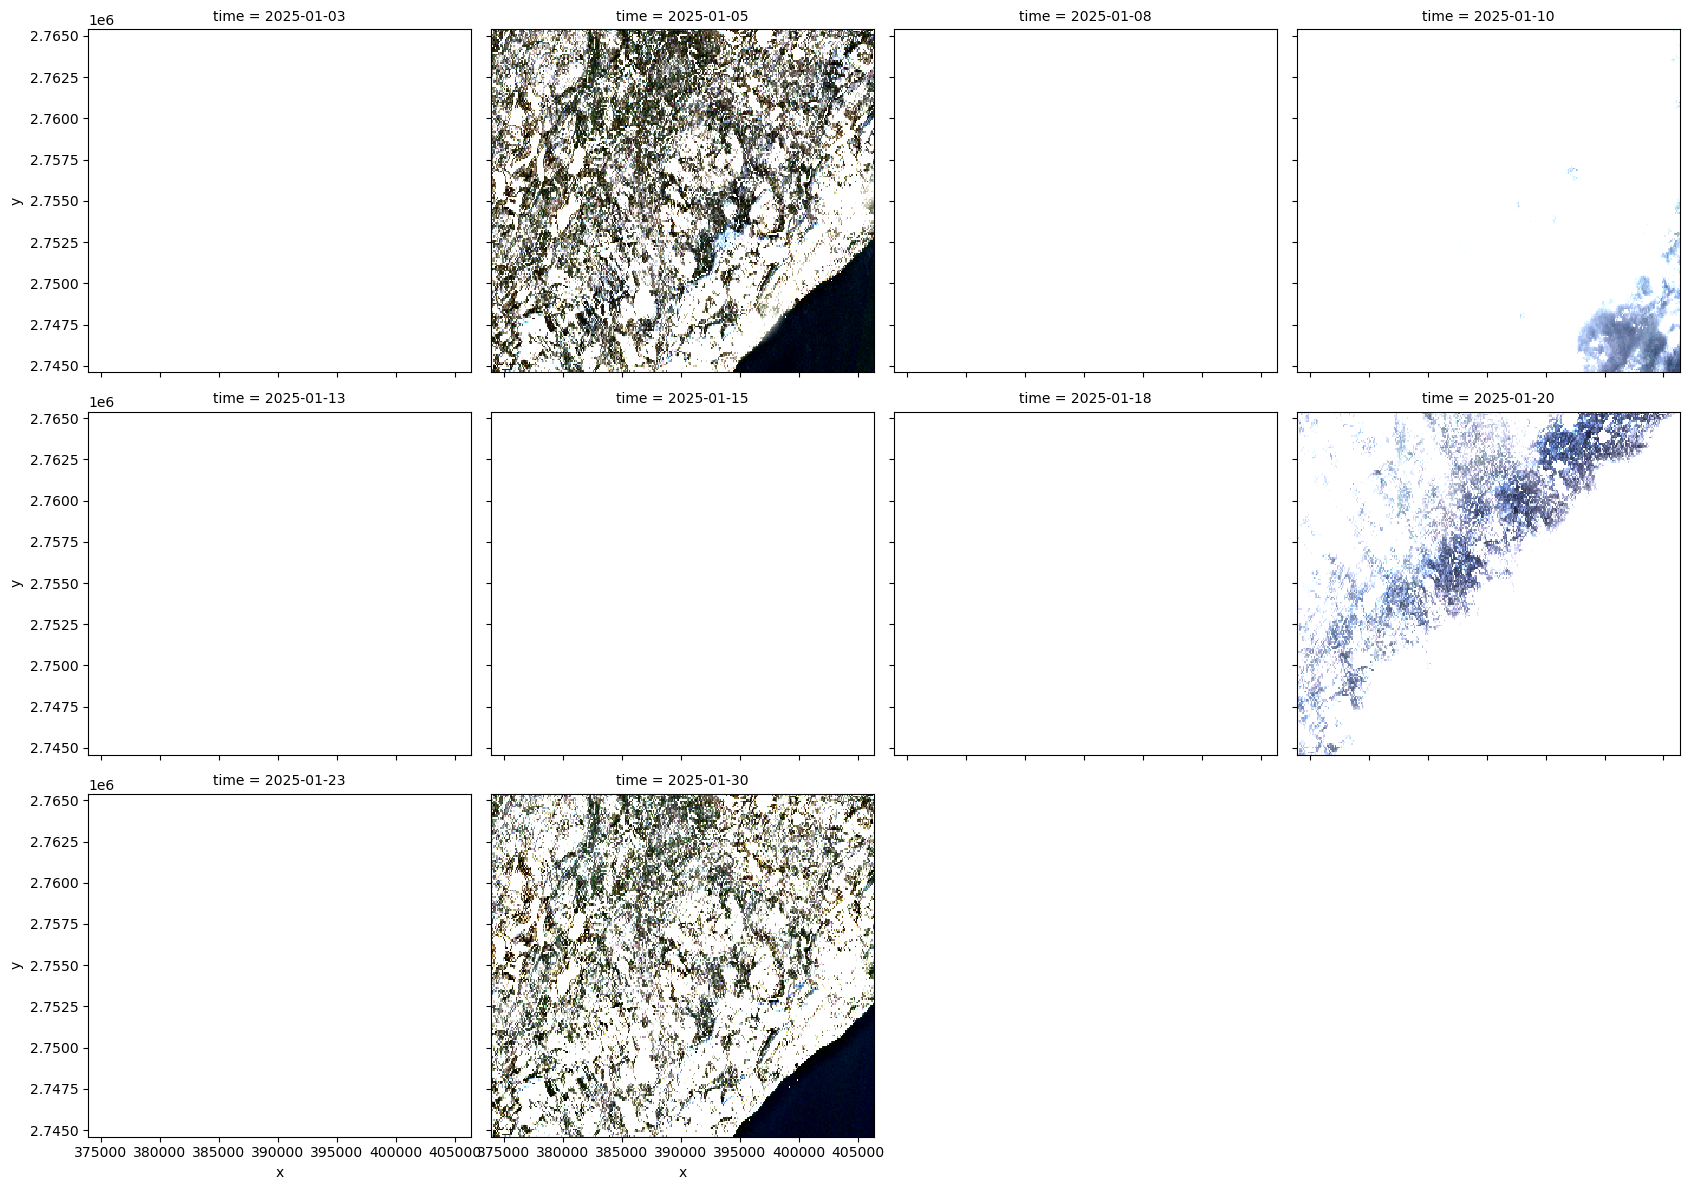

In [20]:
flat_stack.sel(band=BANDS).plot.imshow(
    col="time",
    col_wrap=4,
    rgb="band",
    robust=True,
    size=4,
    vmin=-0.1,
    vmax=-0.01,
    add_labels=False,
)

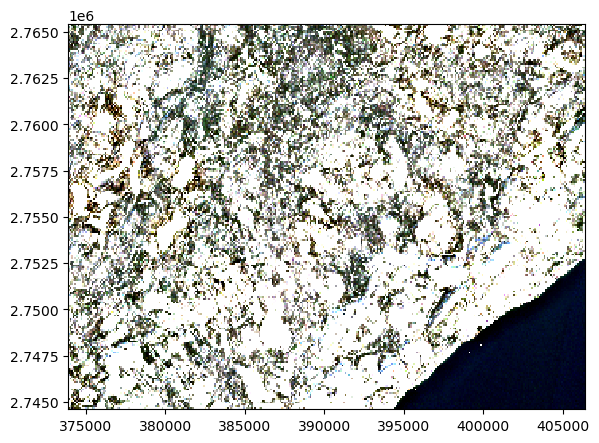

In [21]:
flat_stack.sel(band=BANDS, time="2025-01-30").plot.imshow(
    rgb="band",
    robust=True,
    size=5,
    vmin=-0.1,
    vmax=-0.01,
    add_labels=False,
)

## More examples

Explore more examples in [stackstac documentation](https://stackstac.readthedocs.io/en/latest/index.html).